# Feature correlation

In this example, we show how to use {func}`moscot.problems.time.TemporalProblem.compute_feature_correlation`.

:::{seealso}
- See {doc}`../plotting/100_push_pull` for a demonstration of pull-back and push-forward cell distributions.
:::

## Preliminaries

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import moscot.plotting as mtp
from moscot import datasets
from moscot.problems.spatiotemporal import SpatioTemporalProblem

import squidpy as sq

The {func}`~moscot.datasets.mosta` dataset is a subset of the spatiotemporal transcriptomics atlas of mouse organogenesis {cite}`chen:22`.
Load the dataset and keep the first two timepoints for time efficiency.

In [2]:
adata = datasets.mosta()
adata = adata[(adata.obs["timepoint"] == "E9.5") | (adata.obs["timepoint"] == "E10.5")]
adata.obs["timepoint"] = (
    adata.obs["timepoint"].str[1:].astype("float").astype("category")
)
adata.uns["spatial"] = {}
adata

C:\Users\adwol\AppData\Local\Temp\ipykernel_15268\3954376129.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["timepoint"] = (


AnnData object with n_obs × n_vars = 24162 × 2000
    obs: 'annotation', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'time', 'n_genes', 'total_counts_mt', 'pct_counts_mt', 'Heart_mapping', 'Heart_annotation'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Heart_annotation_colors', 'annotation_colors', 'hvg', 'moscot_results', 'spatial'
    obsm: 'spatial'
    layers: 'count'

Create and solve the {class}`~moscot.problems.spatiotemporal.SpatioTemporalProblem`.

In [3]:
stp = (
    SpatioTemporalProblem(adata)
    .prepare(time_key="timepoint", spatial_key="spatial")
    .solve(alpha=0.5, epsilon=0, rank=500)
)

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                  
INFO     Normalizing spatial coordinates of `x`.                                                                   
INFO     Normalizing spatial coordinates of `y`.                                                                   
INFO     Solving `1` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(5870, 18292)].                                 


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


WARNING  Solver did not converge                                                                                   


Now we can compute the feature correlation between timepoints:

In [4]:
stp.compute_feature_correlation("timepoint")

,timepoint_corr,timepoint_pval,timepoint_qval,timepoint_ci_low,timepoint_ci_high
Hba-x,0.729827,0.0,0.0,0.723879,0.735666
Marcksl1,0.650324,0.0,0.0,0.642987,0.657541
Ckb,0.621276,0.0,0.0,0.613473,0.628958
Stmn3,0.599778,0.0,0.0,0.591643,0.607790
Tubb3,0.546550,0.0,0.0,0.537646,0.555332
...,...,...,...,...,...
Basp1,-0.324499,0.0,0.0,-0.335735,-0.313172
Ube2c,-0.348375,0.0,0.0,-0.359405,-0.337247
Igfbp5,-0.359259,0.0,0.0,-0.370191,-0.348227
Mest,-0.412677,0.0,0.0,-0.423085,-0.402161


We can calculate the push-forward and pull-back distributions between tha timepoints.
The pull-back distribution corresponds to the set of ancestor cells, while the push-forward distribution corresponds to the set of descending cells.

In [5]:
stp.push(source=9.5, target=10.5)
stp.pull(source=9.5, target=10.5)

Then the feature correlation of the push distribution could be used for target gene detection

In [6]:
stp.compute_feature_correlation("push")

,push_corr,push_pval,push_qval,push_ci_low,push_ci_high
Peg10,0.466855,0.0,0.0,0.456936,0.476658
Mest,0.412855,0.0,0.0,0.402340,0.423260
Igfbp5,0.359293,0.0,0.0,0.348261,0.370225
Ube2c,0.348401,0.0,0.0,0.337274,0.359431
Basp1,0.324471,0.0,0.0,0.313144,0.335707
...,...,...,...,...,...
Tubb3,-0.546640,0.0,0.0,-0.555421,-0.537737
Stmn3,-0.599827,0.0,0.0,-0.607839,-0.591693
Ckb,-0.621311,0.0,0.0,-0.628993,-0.613509
Marcksl1,-0.650382,0.0,0.0,-0.657599,-0.643047


And the feature correlation of the pull distribution could be used for driver gene detection

In [7]:
stp.compute_feature_correlation("pull")

,pull_corr,pull_pval,pull_qval,pull_ci_low,pull_ci_high
Peg10,0.467230,0.0,0.0,0.457315,0.477028
Mest,0.412805,0.0,0.0,0.402290,0.423211
Igfbp5,0.359426,0.0,0.0,0.348396,0.370357
Ube2c,0.348344,0.0,0.0,0.337216,0.359375
Basp1,0.324430,0.0,0.0,0.313101,0.335666
...,...,...,...,...,...
Tubb3,-0.546661,0.0,0.0,-0.555442,-0.537759
Stmn3,-0.599847,0.0,0.0,-0.607859,-0.591713
Ckb,-0.621802,0.0,0.0,-0.629476,-0.614007
Marcksl1,-0.650369,0.0,0.0,-0.657586,-0.643034


Now let's visualize the genes with highest absolute correlation values:

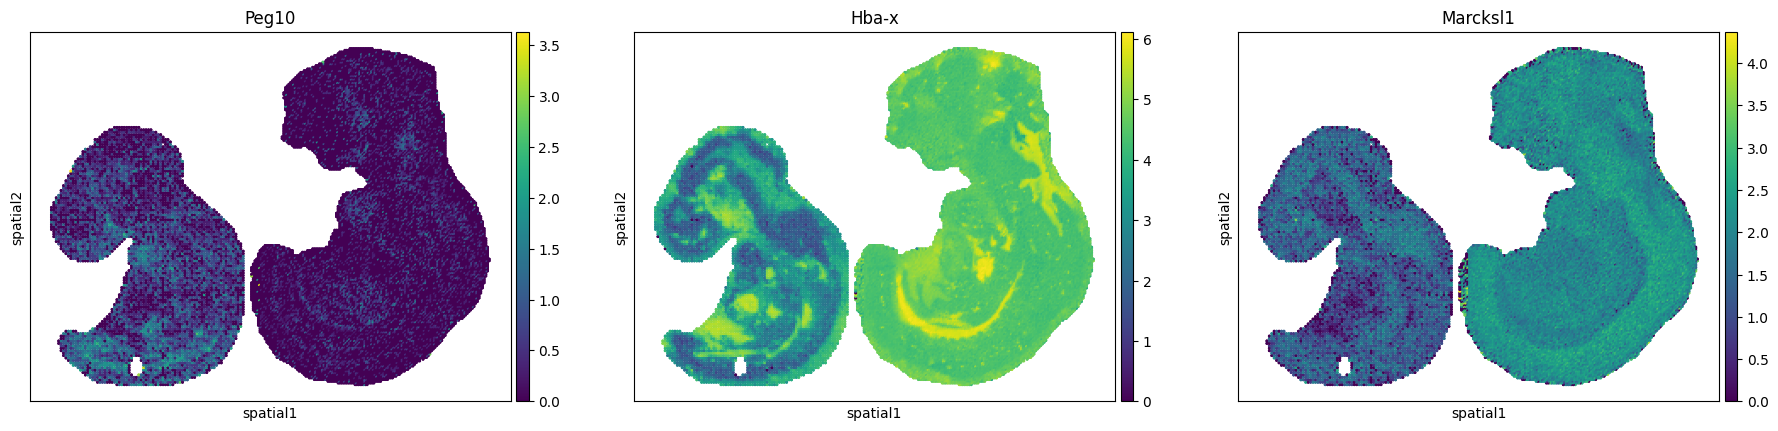

In [8]:
sq.pl.spatial_scatter(
    adata, color=["Peg10", "Hba-x", "Marcksl1"], spatial_key="spatial", shape=None
)

We can see that the expression of `Peg10` decreases between timepoints, and `Hba-x` and `Marcksl1` increase.